In [370]:
#Lucas Ross 15 Mar 2023

#import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns

## Part 1: Data Pre-Processing

In [371]:
#set options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

#import and read dataset
df = pd.read_csv("online_shoppers.csv")
print(df.shape)
df.head(5)
df.tail(5)

(12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False
12329,0,0.0,0,0.0,3,21.250000,0.000000,0.066667,0.000000,0.0,Nov,3,2,1,2,New_Visitor,True,False


In [372]:
df = df.drop_duplicates() #drop duplicated rows

In [373]:
#data type of each column
df.dtypes

#we dont have to parse boolean, its automatically written as 0s and 1s

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [374]:
df.isna().sum() #no null values

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [375]:
categorical = ["Weekend", "Revenue", "VisitorType", "Month"] #categorical variables
numeric = df.drop(categorical, axis=1, inplace=False) #numeric variables

for i in categorical:
    print(df[i].value_counts())
    print("\n")

#most visitors are returning! it is notable that theres an "other" column that might make overfitting an issue
#weekend false > true because 5 weekdays vs 2 weekends
#revenue is mostly false

False    9346
True     2859
Name: Weekend, dtype: int64


False    10297
True      1908
Name: Revenue, dtype: int64


Returning_Visitor    10431
New_Visitor           1693
Other                   81
Name: VisitorType, dtype: int64


May     3329
Nov     2982
Mar     1860
Dec     1706
Oct      549
Sep      448
Aug      433
Jul      432
June     285
Feb      181
Name: Month, dtype: int64




In [376]:
numeric.describe().T #statistical summary of numeric vars

#special day is either 1 or 0 because its boolean
#most values for PageValues are 0
#seems like a lot of these variables are right skewed, based on the min, max, and IQR

,count,mean,std,min,25%,50%,75%,max
Administrative,12205.0,2.338878,3.330436,0.0,0.000000,1.000000,4.000000,27.000000
Administrative_Duration,12205.0,81.646331,177.491845,0.0,0.000000,9.000000,94.700000,3398.750000
Informational,12205.0,0.508726,1.275617,0.0,0.000000,0.000000,0.000000,24.000000
Informational_Duration,12205.0,34.825454,141.424807,0.0,0.000000,0.000000,0.000000,2549.375000
ProductRelated,12205.0,32.045637,44.593649,0.0,8.000000,18.000000,38.000000,705.000000
ProductRelated_Duration,12205.0,1206.982457,1919.601400,0.0,193.000000,608.942857,1477.154762,63973.522230
BounceRates,12205.0,0.020370,0.045255,0.0,0.000000,0.002899,0.016667,0.200000
ExitRates,12205.0,0.041466,0.046163,0.0,0.014231,0.025000,0.048529,0.200000
PageValues,12205.0,5.949574,18.653671,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12205.0,0.061942,0.199666,0.0,0.000000,0.000000,0.000000,1.000000


In [377]:
#since VisitorType and Month are strings, convert to numeric with one-hot encoding for decision tree
visitor = pd.get_dummies(df["VisitorType"]) #convert them to 8-bit ints
month = pd.get_dummies(df["Month"])

df.drop(["VisitorType", "Month"], axis=1, inplace=True)

df = pd.concat([df, visitor, month], axis=1)

df.head(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,New_Visitor,Other,Returning_Visitor,Aug,Dec,Feb,Jul,June,Mar,May,Nov,Oct,Sep
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,1,1,1,1,False,False,0,0,1,0,0,1,0,0,0,0,0,0,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,1,2,False,False,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,4,1,9,3,False,False,0,0,1,0,0,1,0,0,0,0,0,0,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,3,2,2,4,False,False,0,0,1,0,0,1,0,0,0,0,0,0,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,3,3,1,4,True,False,0,0,1,0,0,1,0,0,0,0,0,0,0


## Part 2: Exploratory Data Analysis

In [378]:
def univariate_numeric(data, col, figsize=(15, 10), kde=False, bins=None):
    fig, (ax_box, ax_hist) = plt.subplots(
        nrows=2,
        sharex=True, #xaxis is same across subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)}, #ratio of heights
        figsize=figsize)
    sns.boxplot(data=data, x=col, ax=ax_box, showmeans=True)
    sns.histplot(data=data, x=col, kde=kde, ax=ax_hist)

'\nobservations:\n- most of these are VERY right-skewed\n- BounceRates mean is outside IQR (aka lots of high-value outliers)\n- ExitRates is very dispersed (a little more normally distributed?)\n- SpecialDay mean is outside IQR and min/max\n- Region is probably the most normally distributed (aka least amount of outliers)\n- TrafficType mean is outside IQR\n'

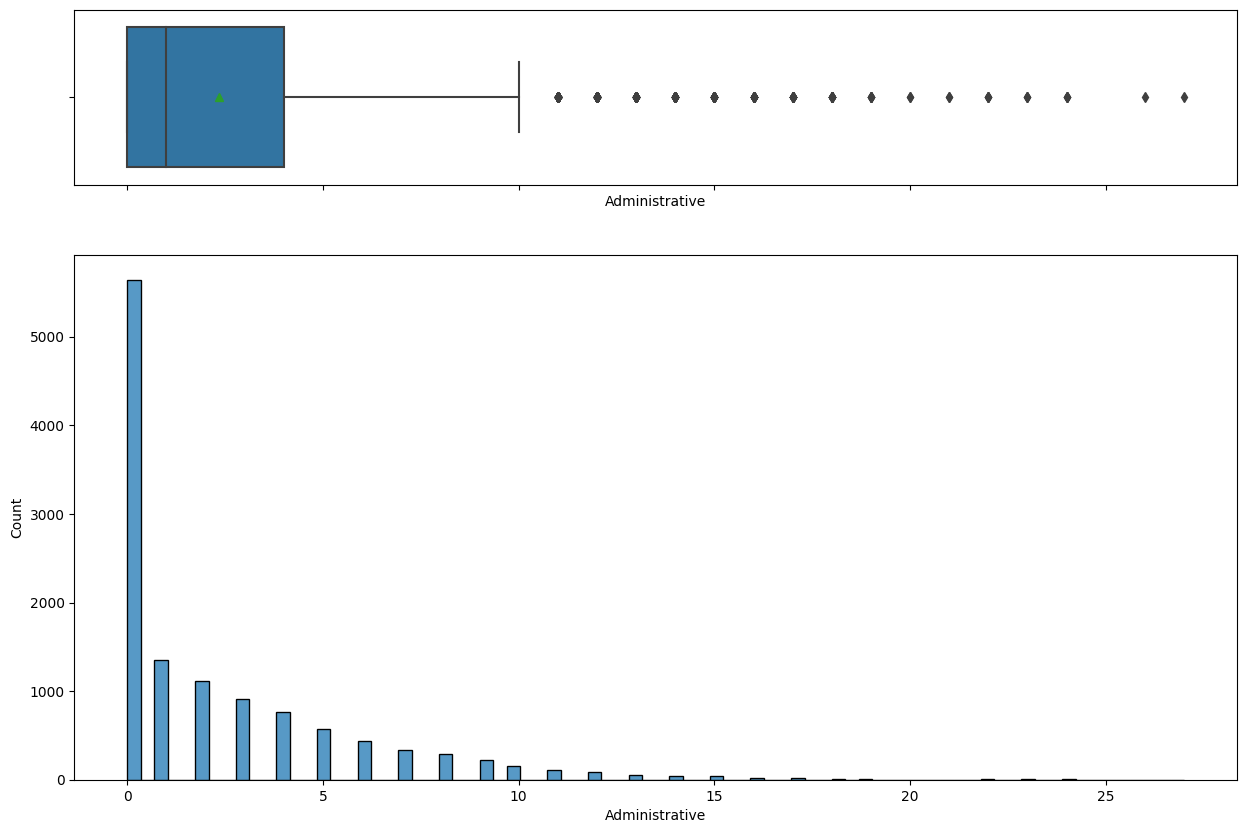

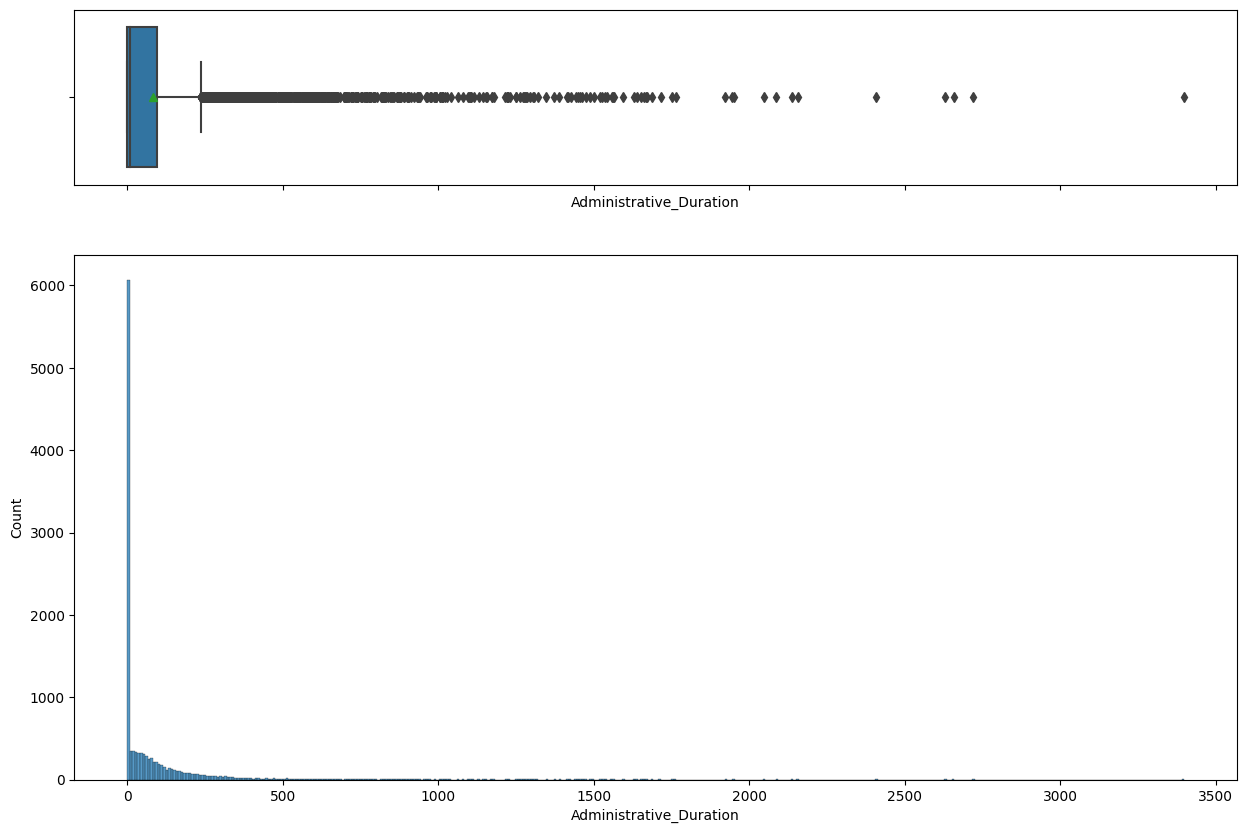

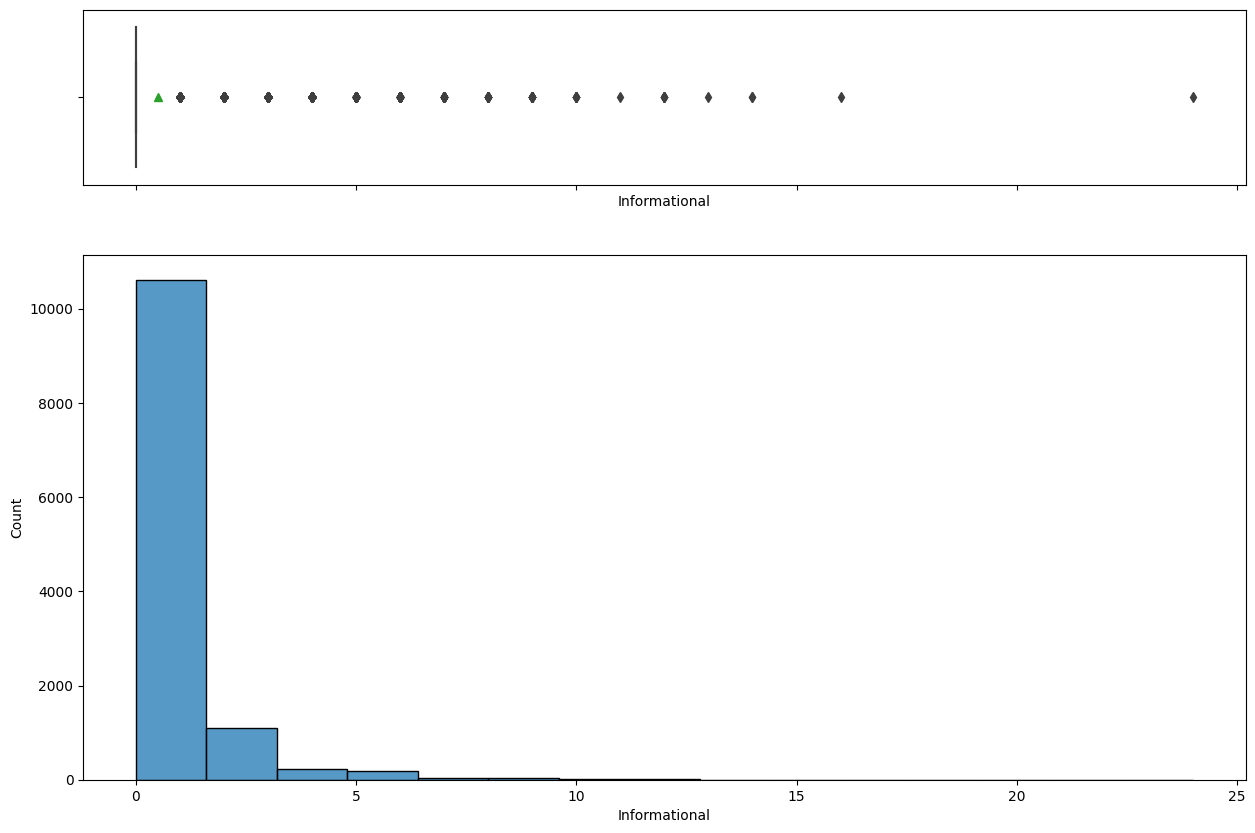

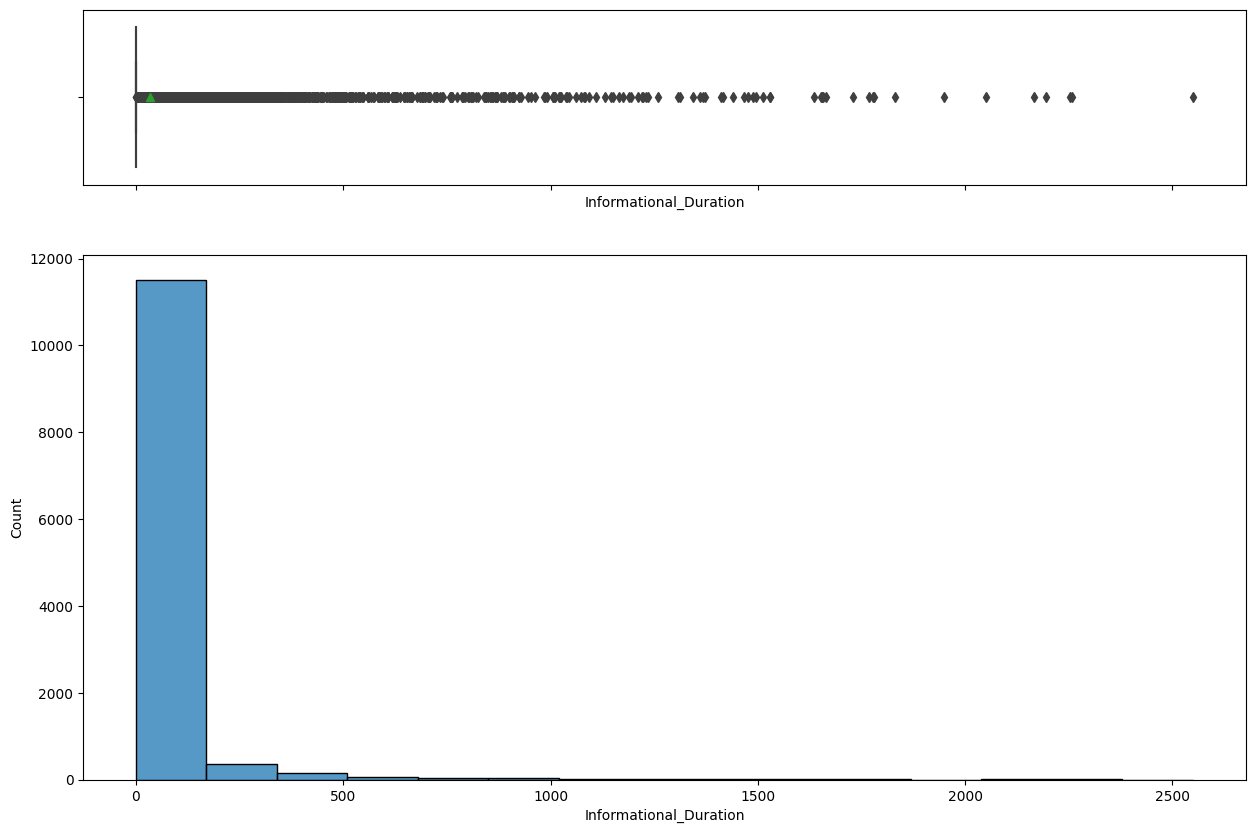

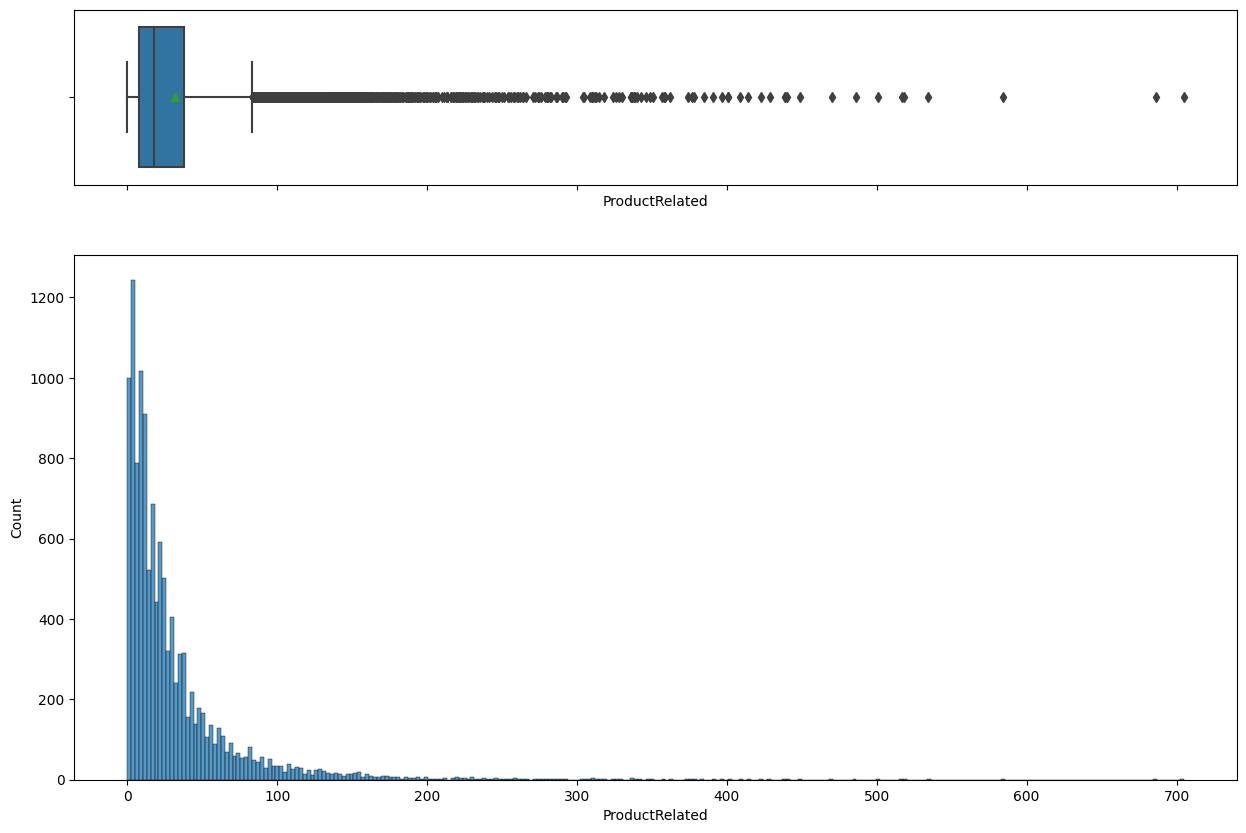

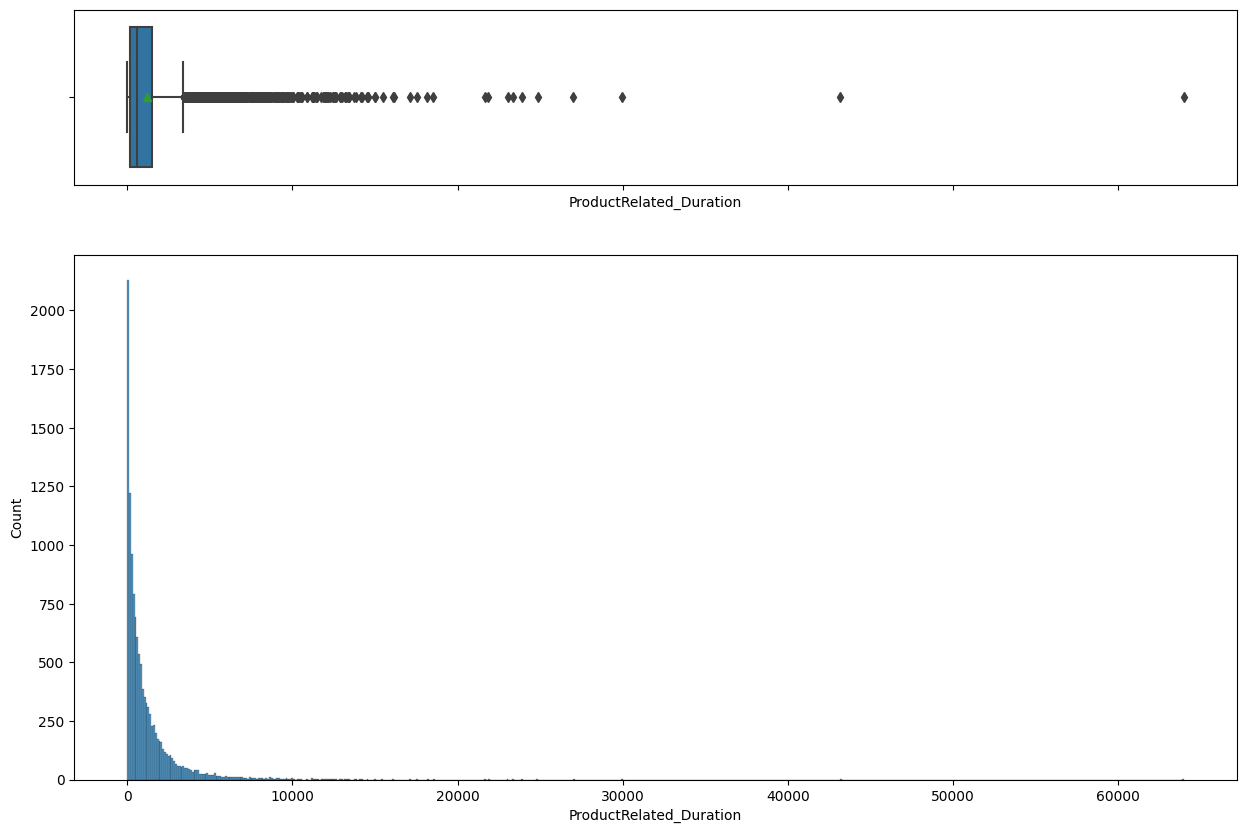

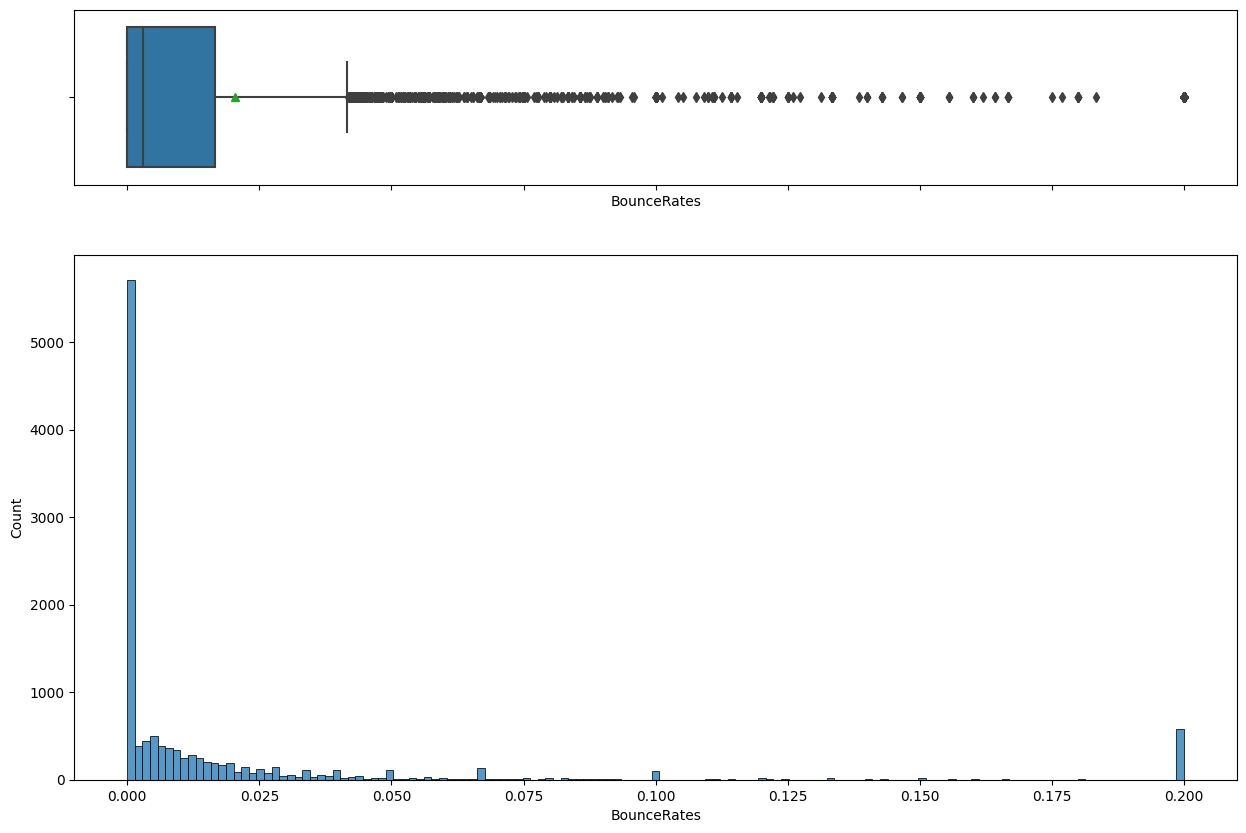

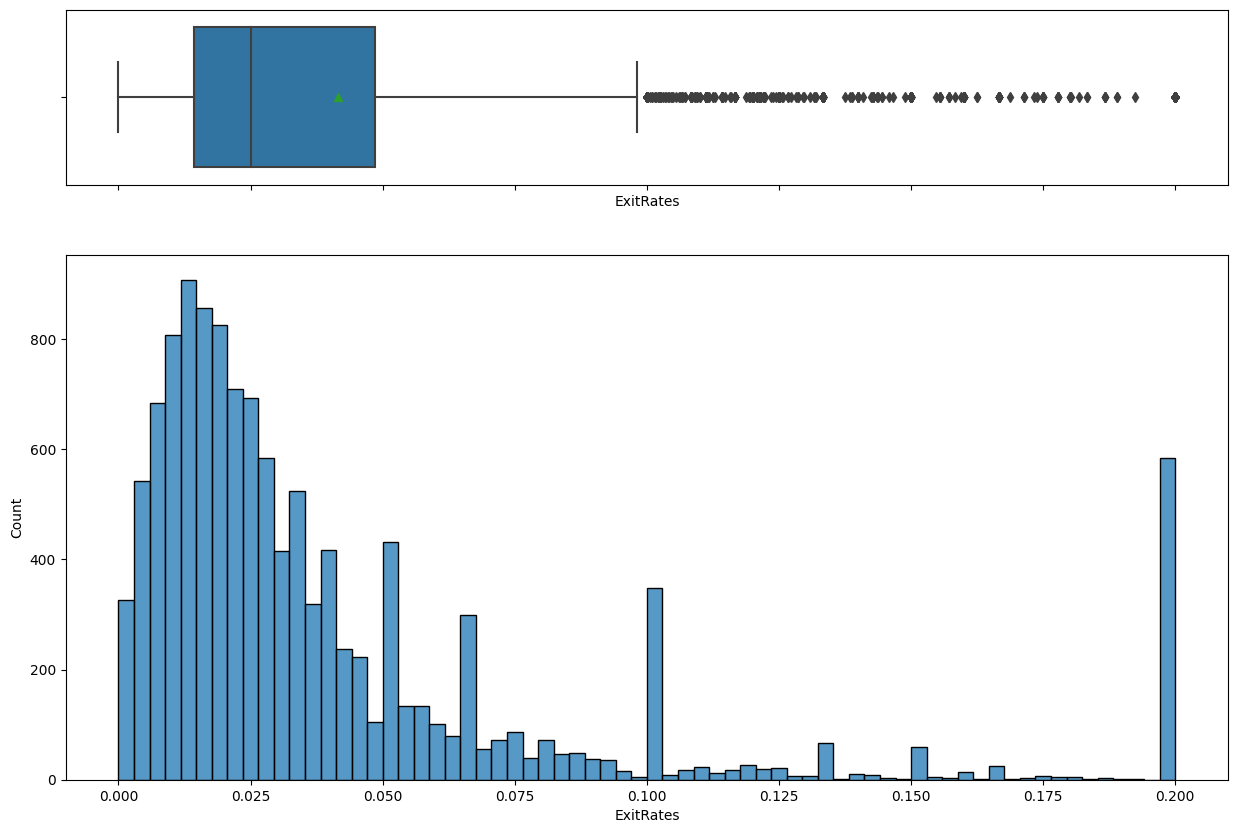

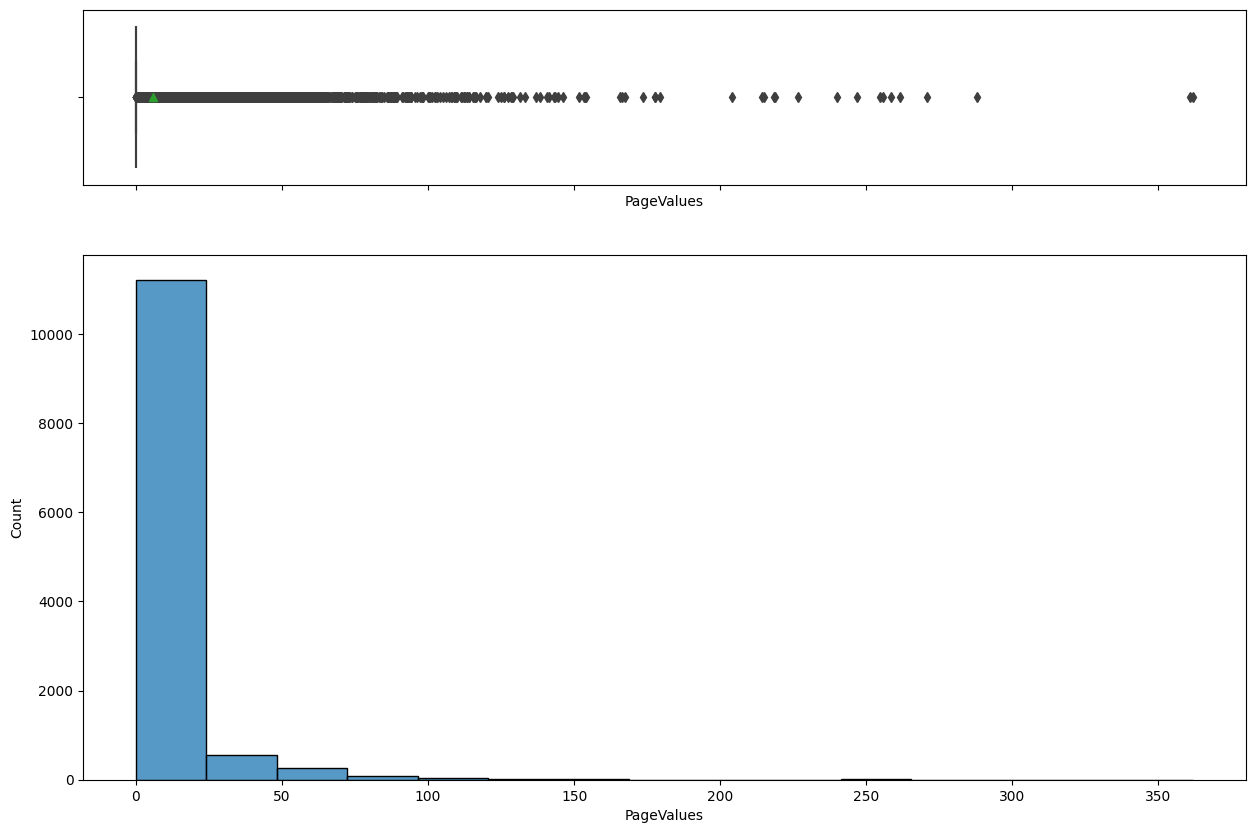

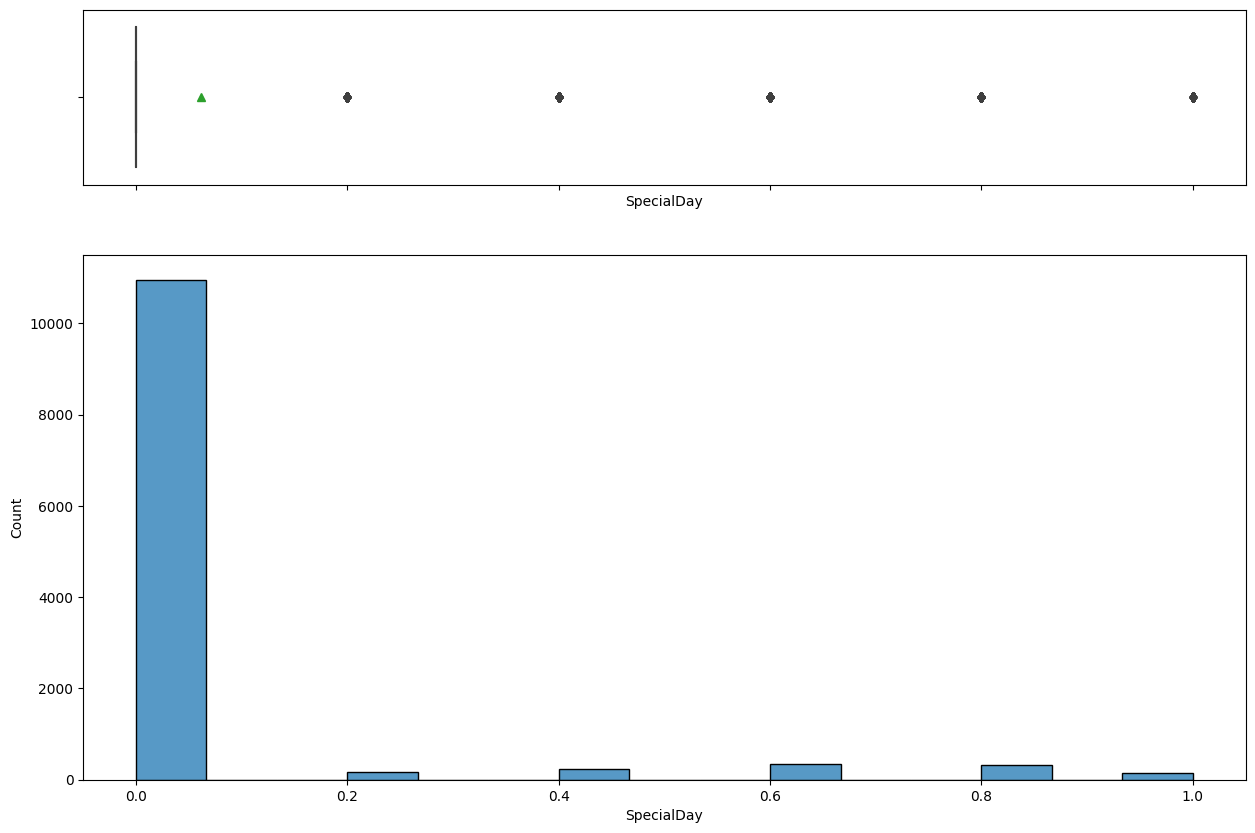

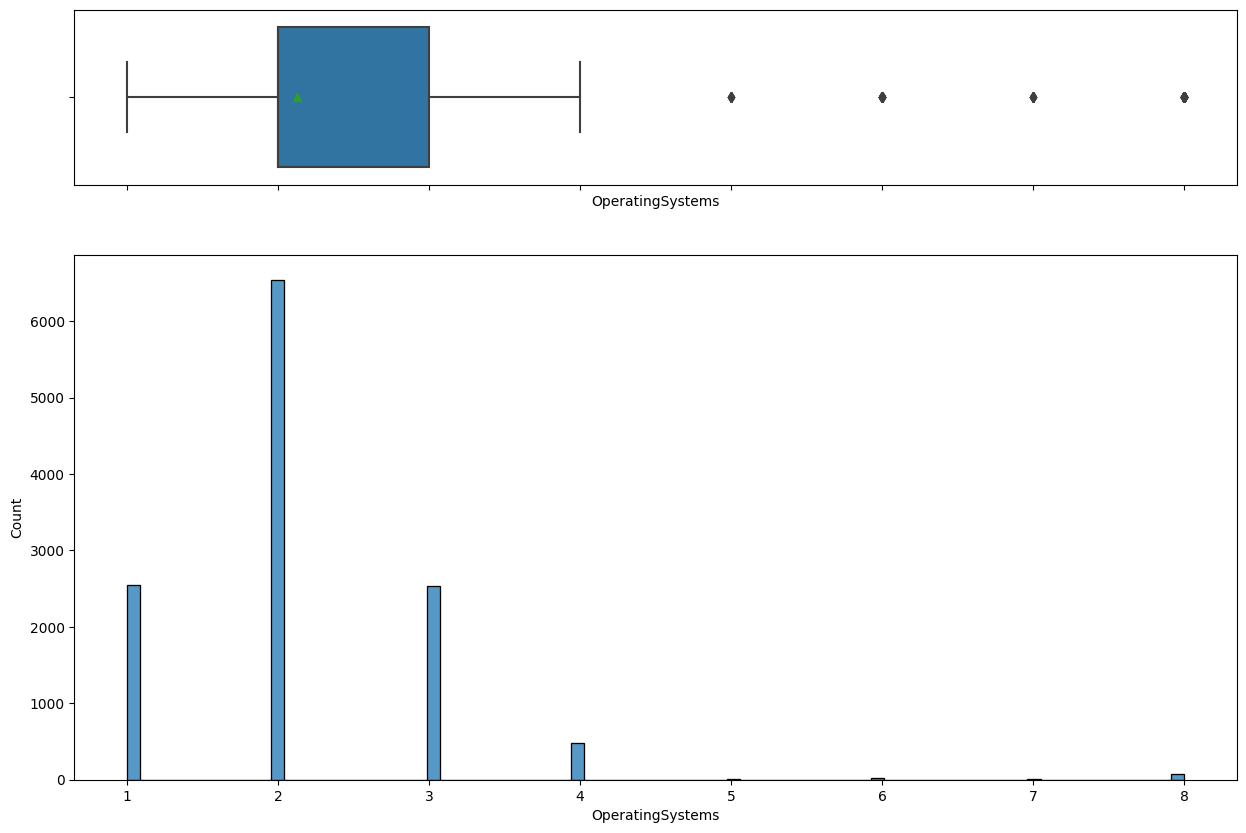

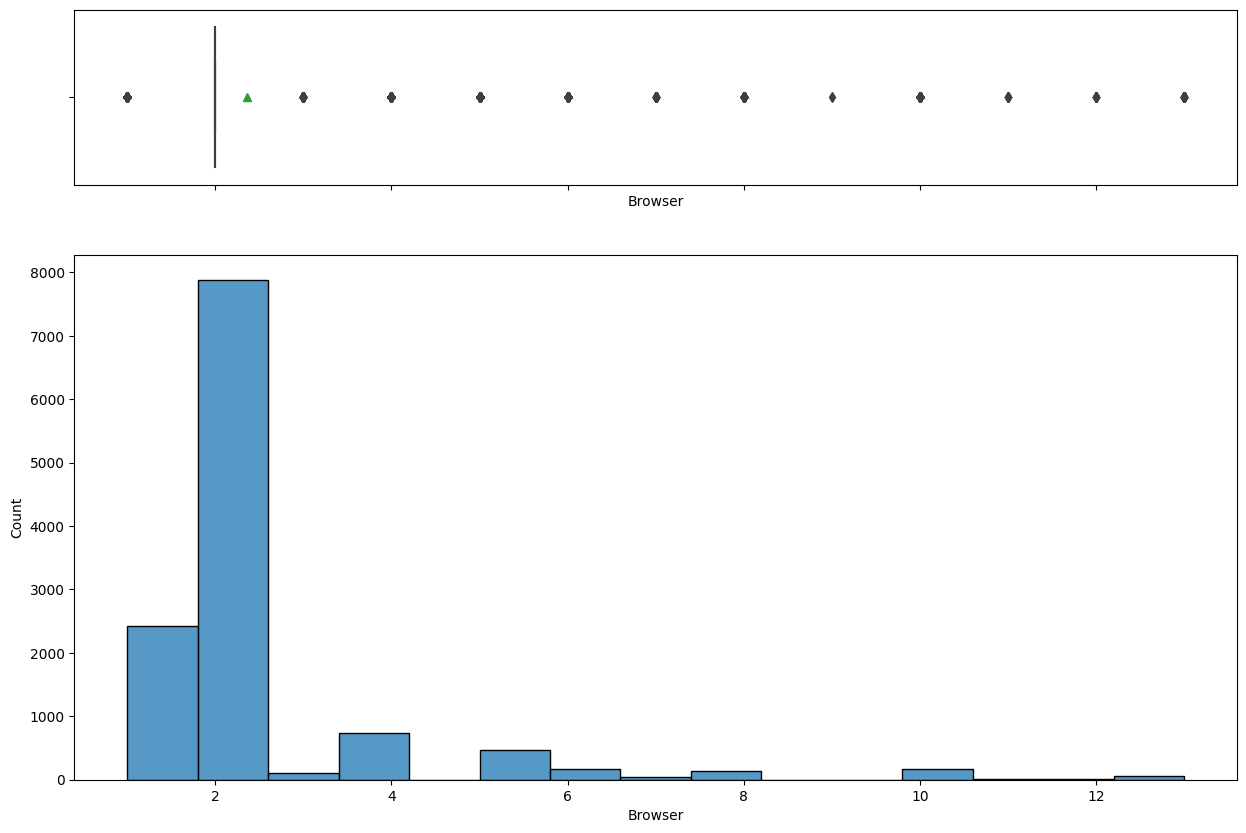

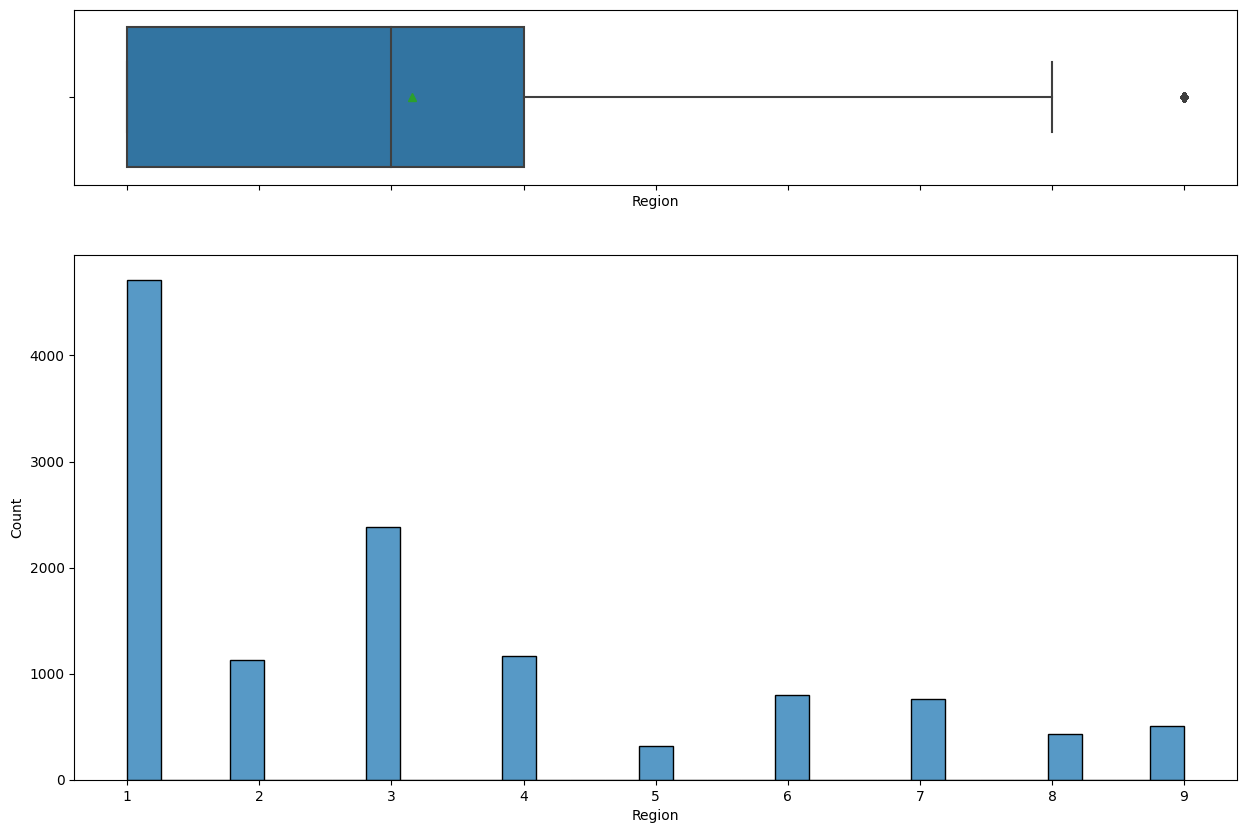

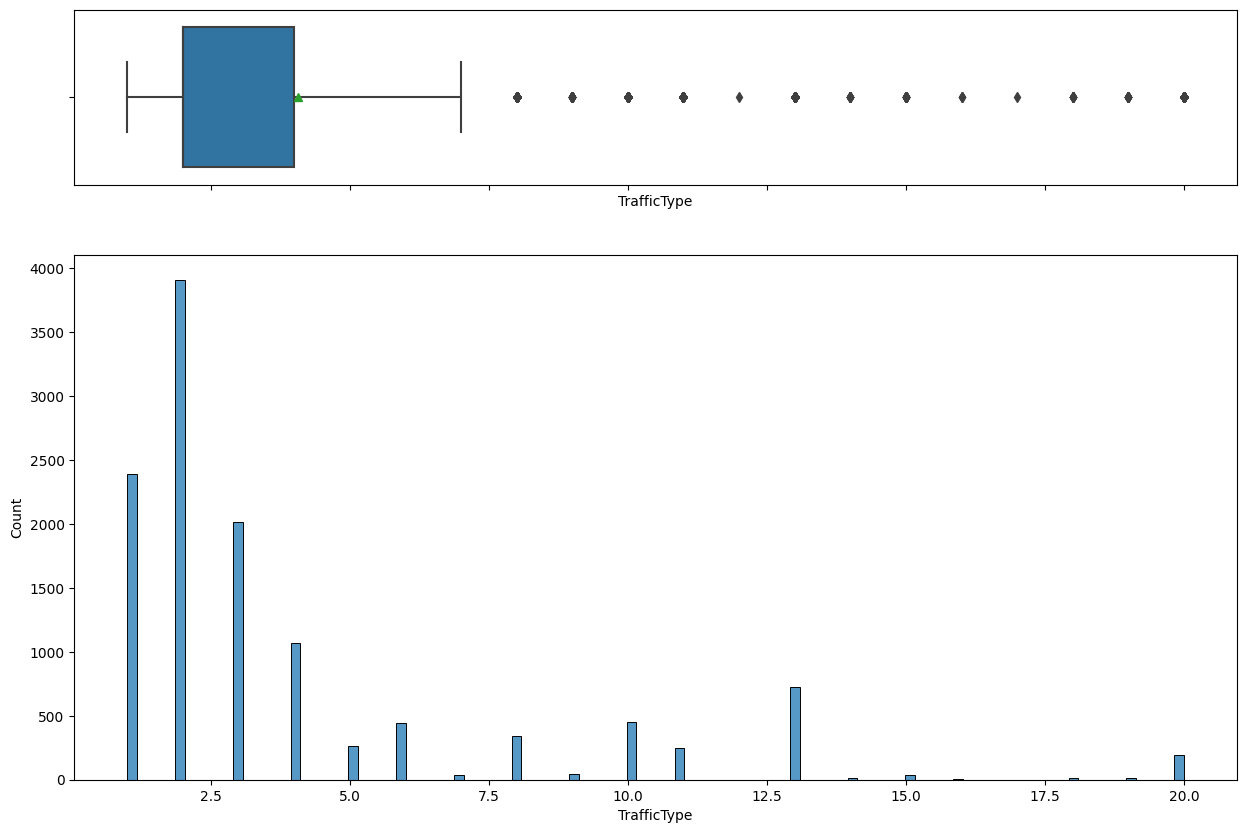

In [379]:
for i in numeric:
    univariate_numeric(df, i)

'''
observations:
- most of these are VERY right-skewed
- BounceRates mean is outside IQR (aka lots of high-value outliers)
- ExitRates is very dispersed (a little more normally distributed?)
- SpecialDay mean is outside IQR and min/max
- Region is probably the most normally distributed (aka least amount of outliers)
- TrafficType mean is outside IQR
'''

## Part 3: Decision Tree

In [380]:
#make x and y
x = df.drop(["Revenue"], axis=1)
y = df["Revenue"]

In [381]:
#split data
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=1)

In [382]:
#make model and fit
model = tree.DecisionTreeClassifier()
model.fit(xtrain, ytrain)

DecisionTreeClassifier()

In [383]:
model.score(xtest, ytest) #86% accuracy

0.8607318405243036

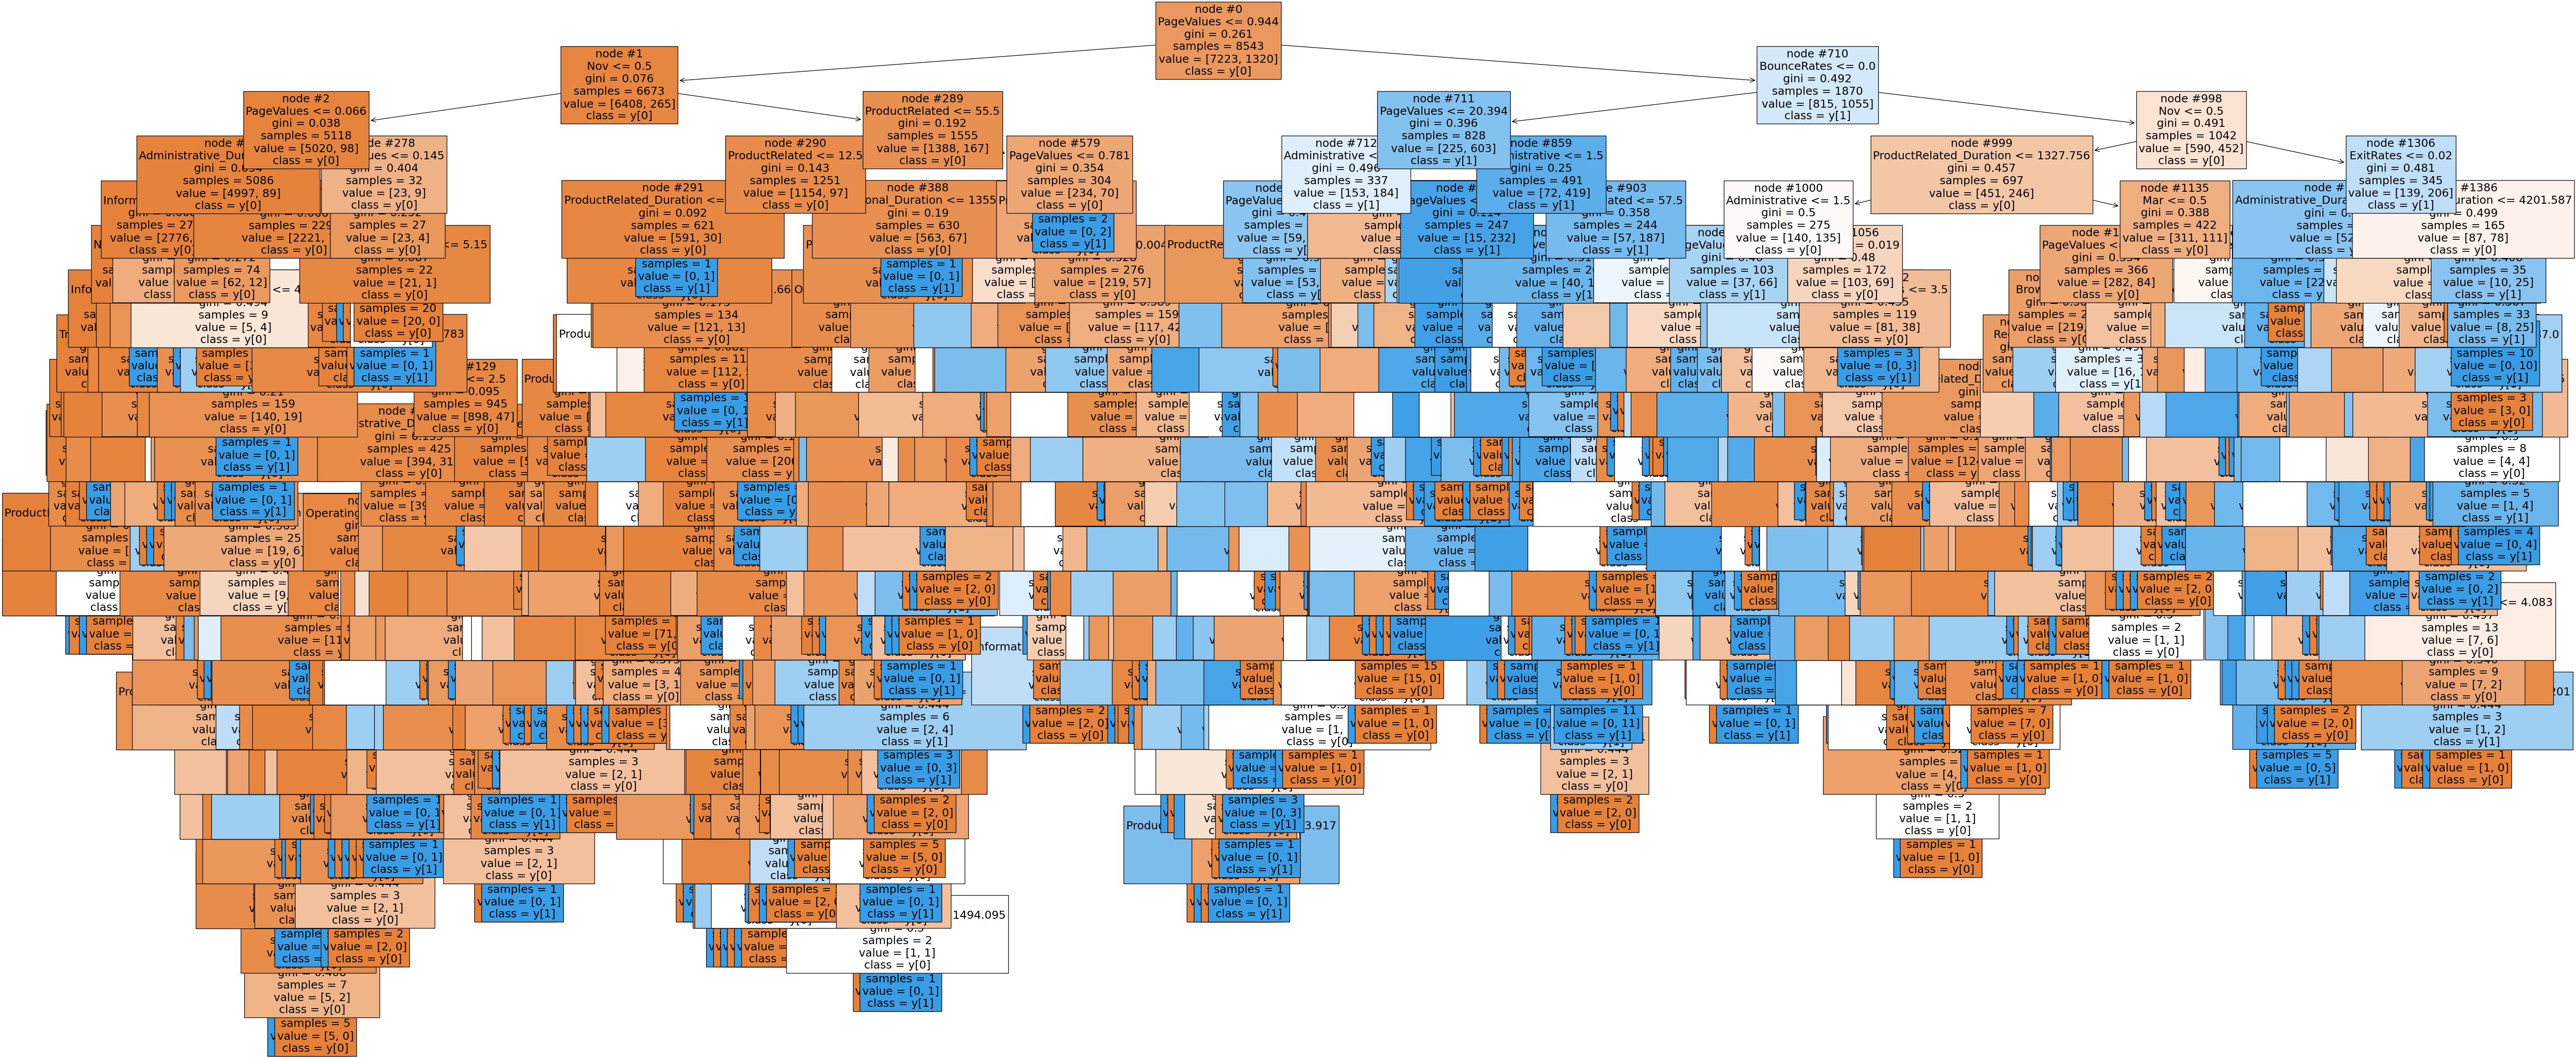

In [384]:
#tree visualization
plt.figure(figsize=(70, 30))
fig = tree.plot_tree(model,
    feature_names=x.columns,
    node_ids=True,
    class_names=True,
    fontsize=18,
    filled=True)